# Übungsblatt 2 (Sprach- und Signalverarbeitung)

> In this exercise session the topic of frequency domain signal analysis is tackled. Here, you will write another
function which takes the segmented blocks from the previous exercise as an input argument and uses them to
compute a short-time Fourier transform (STFT). Further, you will write a function which reconstructs the time
domain signal from an STFT.

> Download the file _Exercise2.zip_ from STiNE which contains the signals _speech1.wav_ and _phone.wav_.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import sounddevice as sd

#read-Objekte
file_speech1 = wave.open('./Audio/speech1.wav','r')
file_phone = wave.open('./Audio/phone.wav')

#Abtastwerte
speech1_samples = np.frombuffer(file_speech1.readframes(-1),'int16')
phone_samples = np.frombuffer(file_phone.readframes(-1),'int16')

#Abtastrate
speech1_fs = file_speech1.getframerate()
phone_fs = file_phone.getframerate()

#Time-Domain
speech1_time = np.linspace(0, len(speech1_samples)/speech1_fs, num=len(speech1_samples))
phone_time = np.linspace(0, len(phone_samples)/phone_fs, num=len(phone_samples))

In [3]:
#sound speech1
sd.play(speech1_samples, speech1_fs)

In [4]:
#sound phone
sd.play(phone_samples,phone_fs)

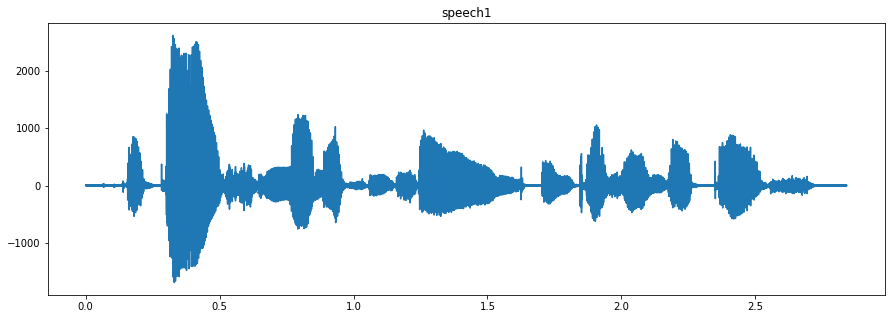

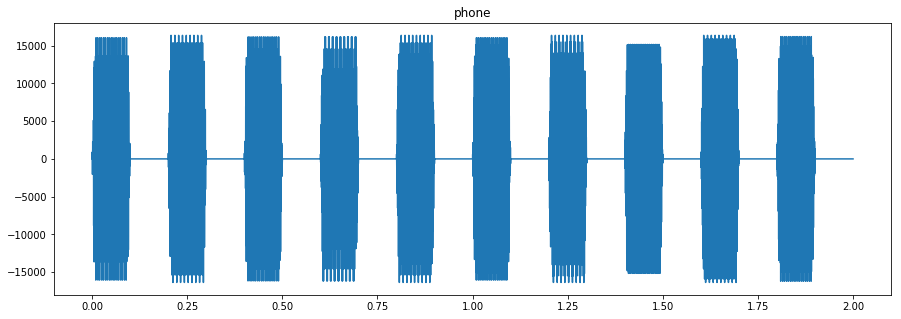

In [75]:
#plots
plt.figure(figsize=(15,5))
plt.title('speech1')
plt.plot(speech1_time,speech1_samples)

plt.figure(figsize=(15,5))
plt.title('phone')
plt.plot(phone_time,phone_samples)
plt.show()

## 1 Short-time Fourier transform

> Write a Matlab function which computes the short-time Fourier transform (STFT). Use your my_windowing
function from the previous session as a starting point, i.e., copy it an rename it to `my_stft.m`. Extend the
function header of the copied version as follows:

> ```
> [ m_stft , v_freq , v_time ] = my_stft ( v_signal, fs, frame_length, frame_shift, v_analysis_window )
> ```

> The input and output parameters are defined as follows:

> - `v_signal` :: vector containing the time domain signal
> - `fs` :: sampling rate in Hz
> - `frame_length` :: frame length in seconds
> - `frame_shift` :: frame shift in seconds
> - `v_analysis_window` :: vector containing that contains the spectral analysis window (This vector should have the same length as the frames, i.e., frame_length in samples)

> - `m_stft` :: a matrix which stores the complex short-time spectra in each column
> - `v_freq` :: a vector which contains the frequency axis (in units of Hertz) corresponding to the computed spectra
> - `v_time` :: time steps around which a frame is centered (as in previous exercise)

> The function needs to be extended by the following steps. They need to be performed for each frame:
> 1. After you extracted a frame from the signal, the analysis window needs to be applied.
> 2. Use the built-in Matlab function `fft` to calculate the DFT.
> 3. Only keep the lower half of the spectrum and remove the upper half. Make sure that the frequency bin at the Nyquist frequency is still included.
>   - Why are the computed spectra complex conjugate symmetric?
>   - What may be the advantage of only considering one half of the spectrum?
>   - How can you compute the frequency for each spectral bin? How many sampling points does the spectrum have after you removed the mirrored part while including the Nyquist frequency bin?
> 4. Store the transformed frames in the columns of the output matrix `m_stft`.

In [106]:
def my_shift(v_signal, fs, frame_length, frame_shift):
    length_nu = int(frame_length * fs)
    shift_nu = int(frame_shift * fs)
    frames_nu = int((len(v_signal) - length_nu + shift_nu) / shift_nu)
    
    Matrix = np.zeros(shape=(length_nu,frames_nu))
    for frame_index in range(0,frames_nu-1):
        column = v_signal[frame_index * shift_nu : frame_index * shift_nu + length_nu]
        Matrix[:,frame_index] = column
    time_steps = [i * shift_nu + (length_nu - shift_nu) for i in range(0,frames_nu)]
    return Matrix, time_steps   
    
m,y = my_shift(phone_samples,phone_fs,32e-3,16e-3)
print(phone_fs * 32e-3)
print(m.shape)
print(len(y))

512.0
(512, 124)
124


In [105]:
from scipy.fftpack import fft

def my_stft(v_signal, fs, frame_length, frame_shift, v_analysis_window):
    matrix, v_time = my_shift(v_signal, fs, frame_length, frame_shift)
    windowedarray = [frame * np.array(v_analysis_window) for frame in matrix.T]
    fftarray = [fft(windowedframe)[0: int(len(windowedframe)/2)] for windowedframe in windowedarray]
    m_stft = np.array(fftarray).T
    v_freq = np.linspace(0,fs/2,frame_length * fs / 2)
    return m_stft, v_freq, v_time

X, v_fre, v_time = my_stft(phone_samples,phone_fs,32e-3,8e-3,[1] * int(phone_fs * frame_length))
print(len(v_time))
print(X.shape)

247
(256, 247)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


## 2 Spectral Analysis

> If not stated otherwise, the following exercises should be performed for both signals.




### (a)

> Use your own function to compute the STFT and plot the logarithmic magnitude spectrogram in dB using the following parameters.
>   - frame length: 32 ms
>   - frame shift: 8 ms
>   - window function: periodic Hann window
>    You can create the Hann window with `v_analysis_window = hann(frame_length_samples, 'periodic')`, where
`frame_length_samples` is the frame length in samples.
>    The spectrogram can be plotted using the following Matlab command
>    ```imagesc ( v_time , v_freq , 10* log10 ( max ( abs ( m_stft ) .^2 , 10^( -15) ) )```
>    It tells Matlab to use the vector `v_time` for the x-axis and `v_freq` for the y-axis. Here, the vector `v_time` contains the time instants for each block / each spectrum.
>    The `imagesc` command uses by default a reversed y-axis.
>    The axis can be inverted by using `axis xy` after the `imagesc` call.
>    - Why is the magnitude plotted in dB? Why is it reasonable to introduce a lower limit? What is the lower limit in the command given above in dB?

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


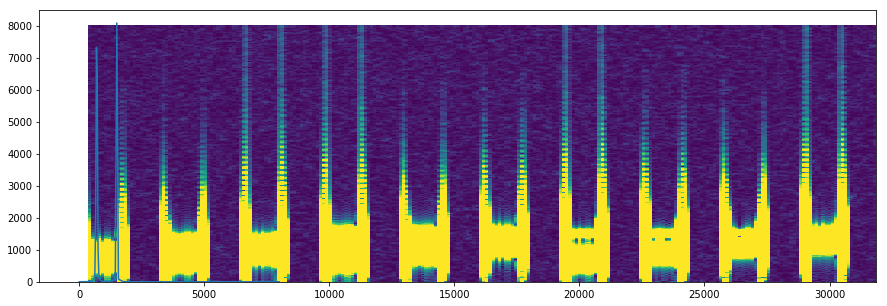

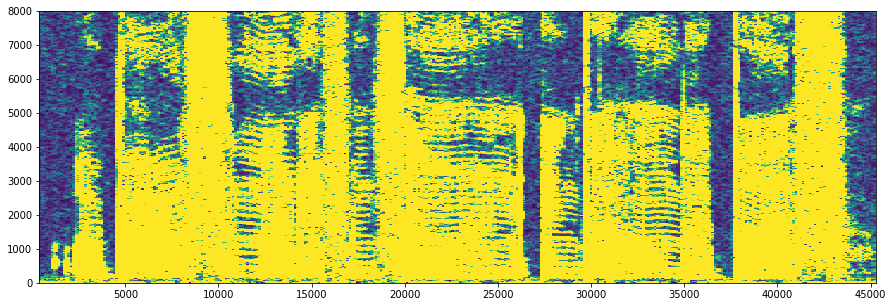

In [124]:
import scipy as sy
frame_length = 32e-3
frame_shift = 8e-3
window_function = sy.signal.hann(int(frame_length * phone_fs))
X, v_fre, v_time = my_stft(phone_samples,phone_fs,frame_length,frame_shift,window_function)
s_X, s_v_fre, s_v_time = my_stft(speech1_samples,speech1_fs,frame_length,frame_shift,window_function)
plt.figure(figsize=(15,5))
plt.plot(v_fre,2/len(X.T[0]) * abs(X.T[150]))
plt.pcolormesh(v_time, v_fre, np.abs(X), vmin=0, vmax=100)
plt.show()
plt.figure(figsize=(15,5))
plt.pcolormesh(s_v_time, s_v_fre, np.abs(s_X), vmin=0, vmax=np.sqrt(8000))
plt.show()

### (b)

> Identify the voiced, unvoiced and silence segments in the spectrogram by eye.
>    - Describe their appearance and what distinguishes them. Is it possible to identify the different voicing types more easily in comparison to the time domain representation?

### (c)

> Produce the same plot as in a) but this time using a frame length corresponding to 8 ms and a frame shift of 2 ms.
>    Further, create a plot for a frame length of 128 ms and a frame shift of 32 ms.
>    - How well can you distinguish single sinusoidal components? Short impulses? Explain the influence of the different parameter settings.


### (d)

> Only for the speech signal estimate the fundamental frequency using the auto-correlation-based method of the last exercise session. Plot the estimated fundamental frequency onto the spectrogram. The parameter setting should be the one used in a). This can be achieved by issuing the following commands after the `imagesc` command:
>    ```
>    hold on
>    plot ( v_time , v_fundamental_frequency , ’k ’)
>    hold off
>    ```
>   - Do the estimated fundamental frequencies follow the harmonic structures in the spectrogram? You may also want to plot higher harmonics by multiplying your estimated fundamental frequencies with a positive integer value. This way, you can see the precision of the estimated frequencies more precisely.

## 3 Synthesis from the STFT domain (Inverse STFT)

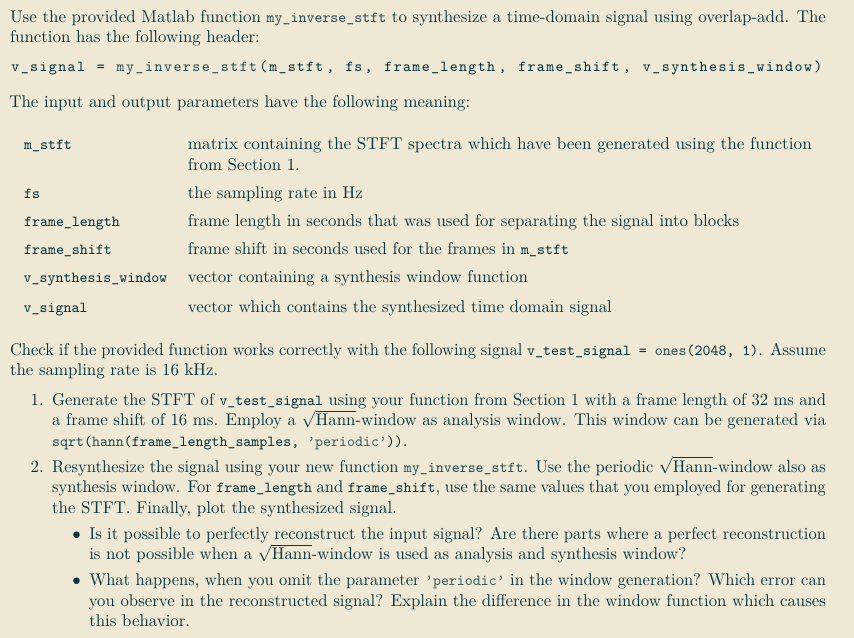